In [1]:

%load_ext autoreload
%autoreload 2
import bnl
from bnl import viz

## Let's plot!

- Figure 1: how framesize affect the triplet metrics
- Figure 2: how continuous compares with 0.5: scatter plot


687-0
687-1


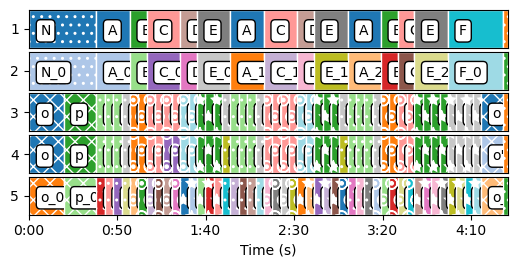

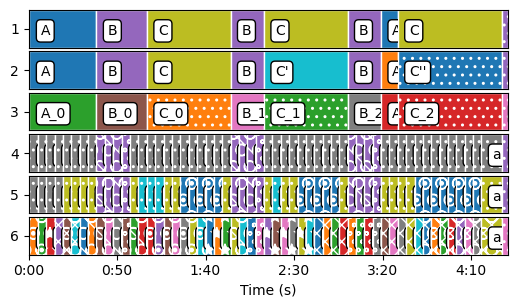

In [2]:
import random
tids = bnl.fio.salami_tids()
tid = random.choice(tids)
salami_hiers = bnl.fio.salami_ref_hiers(tid=tid)
while len(salami_hiers) < 2:
    tid = random.choice(tids)
    salami_hiers = bnl.fio.salami_ref_hiers(tid=tid)

hiers = {'-'.join([str(tid), str(i)]): h for i, h in enumerate(salami_hiers)}

for tid, h in hiers.items():
    print(tid)
    h.expand(format='slm', always_include=False).plot();

## Comparing Mir_eval implementation and my implementation


### Ok. now I need to do this over all tracks that have 2 annotations and record all the times and results, for several configs


In [ ]:
%load_ext autoreload
%autoreload 2
import bnl
from bnl import metrics
import os, pqdm
import xarray as xr, numpy as np
from pqdm.processes import pqdm
from glob import glob
from tqdm import tqdm

In [ ]:
# Create output directory if it doesn't exist
os.makedirs("./compare_implementation", exist_ok=True)

# Determine number of CPU cores to use
n_jobs = max(1, os.cpu_count() - 1)  # Leave one CPU free

# Process tracks in parallel
tids = bnl.fio.salami_tids()
pqdm(tids, metrics.time_salami_track, n_jobs=n_jobs);

In [ ]:
## Time to collect
track_results_fpaths = glob('./compare_implementation/*.nc')

das = []
for fp in tqdm(track_results_fpaths):
    tid = os.path.basename(fp).split('.')[0]
    # Load the data array and assign the tid as a coordinate
    da = xr.open_dataarray(fp)
    da = da.assign_coords(tid=tid)
    da = da.expand_dims('tid')
    das.append(da)

# Concatenate all the data arrays along the 'tid' dimension
final_da = xr.concat(das, dim='tid')


In [ ]:
#  Save the final data array to a NetCDF file
final_da.to_netcdf('./compare_implementation.nc')

### Alright, I can load from saved data now. Now let's do scatter plot to see how they differ

In [3]:
import importlib
importlib.reload(bnl.viz)

<module 'bnl.viz' from '/Users/xi/code/bnl/bnl/viz.py'>

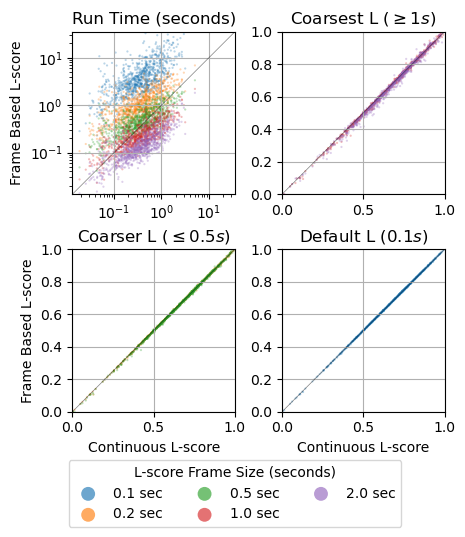

In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from bnl import viz

# Load the data array from the NetCDF file
results = xr.open_dataarray('./compare_implementation.nc')
fig, axes = plt.subplots(2, 2, figsize=(4.5,4.5), constrained_layout=True)
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])
else:
    axes = axes.ravel()


viz.plot_scatter_frame_vs_continuous(
    results, sel_dict=dict(output='run_time'), ax=axes[0]
)
axes[0].set_title('Run Time (seconds)')

viz.plot_scatter_frame_vs_continuous(
    results, sel_dict=dict(output='lm'), frame_sizes=[1,2], ax=axes[1], color_start_idx=3
)
axes[1].set_title('Coarsest L ($\geq 1s$)')

viz.plot_scatter_frame_vs_continuous(
    results, sel_dict=dict(output='lm'), frame_sizes=[0.25, 0.5], ax=axes[2], color_start_idx=1
)
axes[2].set_title('Coarser L ($\leq 0.5s$)')

viz.plot_scatter_frame_vs_continuous(
    results, sel_dict=dict(output='lm'), frame_sizes=[0.1], ax=axes[3], color_start_idx=0
)
axes[3].set_title('Default L ($0.1s$)')

# Set the title for each subplot
# Create the legend for the middle subplot into a row of handle, and plot the thin bar under the how figure
axes[0].set_ylabel('Frame Based L-score')
axes[2].set_ylabel('Frame Based L-score')
axes[2].set_xlabel('Continuous L-score')
axes[3].set_xlabel('Continuous L-score')

# Plot the legend with bigger handles
handles, labels = axes[0].get_legend_handles_labels()
for h in handles:
    h.set_sizes([100])  # Adjust the size as needed
    h.set_alpha(0.65)  # Set transparency for better visibility
leg = fig.legend(handles, labels, 
           loc='lower center', ncol=3, fontsize=10, bbox_to_anchor=(0.5,-0.17)
          )
leg.set_title('L-score Frame Size (seconds)')

# Set all the handles in the plot back to the smaller size.
for ax in axes:
    handles, _ = ax.get_legend_handles_labels()
    for h in handles:
        # Set it back!
        h.set_sizes([2.5])  # Adjust the size as needed
        h.set_alpha(0.3)  # Set transparency for better visibility
    
# Show the plot
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0, wspace=0)
# fig.savefig('../../../text/hier_metric/figs/compare_implementation.pdf', transparent=True, bbox_inches='tight')
fig.savefig('./compare_implementation.pdf', transparent=True, bbox_inches='tight')


## Hierarchical Depth!

Let's get a track from adobe and compare

In [3]:
import bnl, random
from bnl import viz, fio
tids = fio.salami_tids()
random_tid = random.choice(tids)


In [14]:
bad_id='1458'
salami_annos = fio.salami_ref_hiers(tid=bad_id)
salami_adobe = fio.adobe_hiers(tid=bad_id)

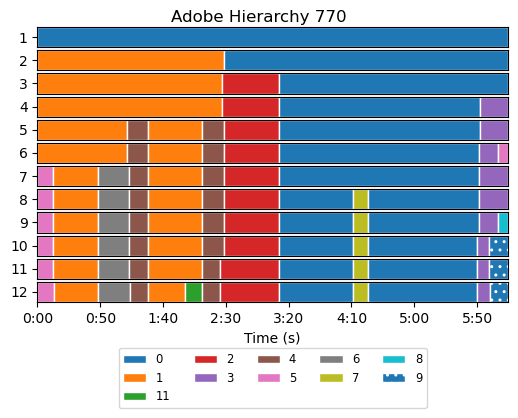

In [5]:
fig, axs = salami_adobe.plot(legend=5, text=False, legend_offset=2, figsize=(5,4.));
fig.suptitle(f'Adobe Hierarchy {random_tid}');

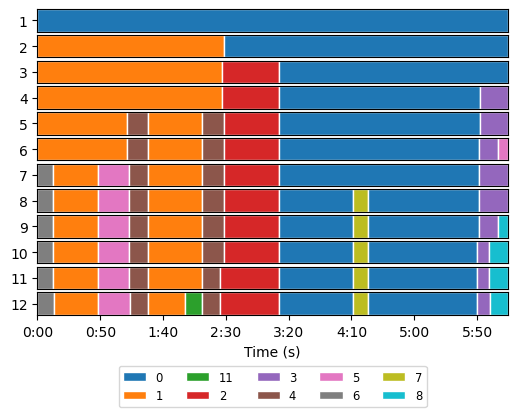

In [7]:
salami_adobe.relabel().plot(legend=5, text=False, legend_offset=2, figsize=(5,4.));

(<Figure size 500x290 with 6 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time (s)'>], dtype=object))

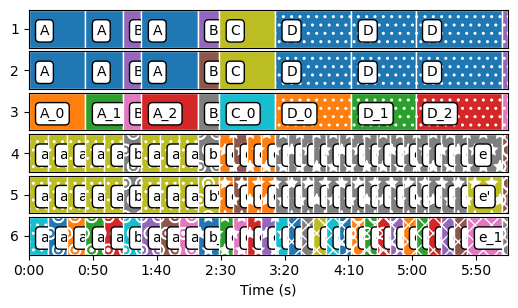

In [28]:
hr.plot()

In [27]:
print(salami_annos[1].T, salami_adobe.T)
hr, he = bnl.mtr.align_hier(salami_annos[0], salami_adobe)
hr = hr.expand()
bnl.mtr.lmeasure(hr, he)

374.6548 374.622


(0.6828832549347276, 0.9538798144432352, 0.7959472750702824)

In [38]:
# Let's get rid of levels and see what happenes


for new_levels in [list(range(x)) for x in range(1, 13)]:
    new_he = bnl.levels2H([he.levels[l] for l in new_levels])
    print(new_levels)
    print(bnl.mtr.lmeasure(hr, new_he))

[0]
(0.34266027780591196, 0.00012623571890510581, 0.0002523784618260422)
[0, 1]
(0.6581936658011615, 0.6795731463818321, 0.6687125683245045)
[0, 1, 2]
(0.6926545525963147, 0.8361129926114956, 0.757652754511553)
[0, 1, 2, 3]
(0.6956489005800305, 0.8792069026274381, 0.77673056028302)
[0, 1, 2, 3, 4]
(0.7054514469663883, 0.9395109533962077, 0.8058291926527081)
[0, 1, 2, 3, 4, 5]
(0.7056384890536834, 0.9415027442302306, 0.8066831920101684)
[0, 1, 2, 3, 4, 5, 6]
(0.6956571429995844, 0.9480288015586521, 0.8024683909441865)
[0, 1, 2, 3, 4, 5, 6, 7]
(0.6850420359263201, 0.9501075221191366, 0.7960905937918014)
[0, 1, 2, 3, 4, 5, 6, 7, 8]
(0.6850744418311399, 0.9508836085628813, 0.7963847938835593)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
(0.6853581535152334, 0.9529612492576849, 0.7973045561901873)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
(0.6846689158186323, 0.9513795015694538, 0.7962844680495973)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
(0.6828832549347276, 0.9538798144432352, 0.7959472750702824)


In [34]:
for x in range(1, len(he.levels) + 1):
    new_levels = list(range(len(he.levels) - x, len(he.levels)))
    # new_levels.reverse()
    new_he = bnl.levels2H([he.levels[l] for l in new_levels])
    print(new_levels)
    print(bnl.mtr.lmeasure(hr, new_he))

[11]
(0.9027779385764622, 0.6228473124352261, 0.7371309728851035)
[10, 11]
(0.8973244392359175, 0.6643869165574928, 0.7634837450903399)
[9, 10, 11]
(0.9000255480312855, 0.6764759985517441, 0.7724009946532311)
[8, 9, 10, 11]
(0.9015321610560229, 0.6851291347050184, 0.7785731599595048)
[7, 8, 9, 10, 11]
(0.8956583777505992, 0.6863716687835092, 0.7771717569377471)
[6, 7, 8, 9, 10, 11]
(0.8989093119210908, 0.7335540979020062, 0.8078571384009704)
[5, 6, 7, 8, 9, 10, 11]
(0.9085913915774447, 0.8676583149135777, 0.8876532087579576)
[4, 5, 6, 7, 8, 9, 10, 11]
(0.9088797688137802, 0.8709141231418888, 0.889492014188317)
[3, 4, 5, 6, 7, 8, 9, 10, 11]
(0.8173827484454703, 0.8814992183617402, 0.8482310930772485)
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
(0.8162596175563637, 0.9537984857846489, 0.8796854586444323)
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
(0.6829752857248348, 0.9538795555721674, 0.796009695640166)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
(0.6828832549347276, 0.9538798144432352, 0.7959472750702824)


(<Figure size 500x290 with 6 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: xlabel='Time (s)'>], dtype=object))

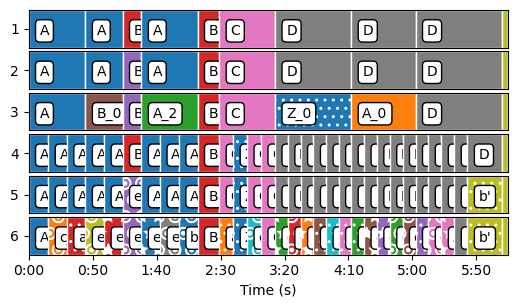

In [36]:
hr.relabel().plot()

In [20]:
bnl.mtr.lmeasure(hr, new_he)

(0.8586787690885265, 0.627727157434456, 0.7252608096499328)

In [13]:
from bnl import metrics, fio
bad_id='1010'
salami_annos = fio.salami_ref_hiers(tid=bad_id)
salami_adobe = fio.adobe_hiers(tid=bad_id)


In [14]:
ref= salami_annos[1]
est= salami_annos[0]
print(metrics.time_lmeasure(ref, est, frame_size=0))
print(metrics.time_lmeasure(ref, est, frame_size=0.5))
print(metrics.time_lmeasure(ref, est, frame_size=0.2))
print(metrics.time_lmeasure(ref, est, frame_size=0.1))

(0.15095305442810059, (0.7366836355959089, 0.736543345875254, 0.7366134840559572))
(0.2579917907714844, (0.7600089438142289, 0.8376851003977025, 0.7969588053590114))
(0.7335591316223145, (0.7558285058507821, 0.834840011231004, 0.7933719332935493))
(1.8798332214355469, (0.7541893548256449, 0.832430667153229, 0.7913808462020459))


In [ ]:
salami_annos[1].labels, salami_annos[0].itvls

In [ ]:
hierarchy.lmeasure(salami_annos[1].itvls, salami_annos[1].labels, salami_annos[0].itvls, salami_annos[0].labels)

In [ ]:
import mir_eval
from mir_eval import hierarchy
hierarchy.lmeasure(salami_annos[1].itvls, salami_annos[1].labels, salami_adobe.itvls, salami_adobe.labels, frame_size=0.1)

In [ ]:
salami_adobe.plot()

In [ ]:
salami_annos[0].T

## Let's investigate!

- Transitivity, and effects of depth.
- Window and its effects. (It's faster now so we probably don't need it. Let's check the original claim that over all frames are redundant)
    - We can visualize this by looking at how window size affect the per time measures iota alpha and rho.
- Monotonicity Meet and its effect.
    - Again look at per time measures and how they change before and after.



In [ ]:
tids = bnl.fio.salami_tids()
hiers = bnl.fio.salami_ref_hiers(tid=tids[0])
hiers

In [ ]:
hiers[0].plot(text=False)